In [1]:
import pandas as pd
from typing import List, Union, Literal, Dict
import numpy as np
from tqdm import tqdm
from crypto_momentum_portfolios.data_loader import CryptoDataLoader
from crypto_momentum_portfolios.utils import get_rebalance_dates

dl = CryptoDataLoader()
dl.assets

['bitcoin',
 'ethereum',
 'bitcoin_cash',
 'ripple',
 'litecoin',
 'tron',
 'ethereum_classic',
 'chainlink',
 'stellar',
 'cardano',
 'dash',
 'tezos',
 'binancecoin',
 'solana',
 'matic_network',
 'dogecoin',
 'avalanche_2']

In [23]:
MOMENTUM_LOOKBACK = 30
univers = (
    dl.get_crypto(
        "all",
        data_frequency="daily",
        fields=["price", "returns", "momentum"],
        flatten_fields_with_crypto=False,
        momentum_lookback=MOMENTUM_LOOKBACK,
    )
    .dropna()
    .loc["2021-10-10":]
)
univers.head()

price                                                  \
                 bitcoin     ethereum bitcoin_cash    ripple    litecoin   
date                                                                       
2021-10-10  55125.460338  3588.080922   615.907754  1.164185  179.983616   
2021-10-11  54711.869597  3431.019307   584.635563  1.136067  175.434910   
2021-10-12  57572.510856  3537.840087   598.546120  1.133037  179.310642   
2021-10-13  56335.035461  3498.105292   585.945981  1.101468  172.387123   
2021-10-14  57487.985880  3605.650334   592.483922  1.128457  177.815385   

                                                                      ...  \
                tron ethereum_classic  chainlink   stellar   cardano  ...   
date                                                                  ...   
2021-10-10  0.103030        55.788961  27.445360  0.354137  2.269474  ...   
2021-10-11  0.097901        53.080199  25.619595  0.333328  2.196016  ...   
2021-10-12  0.097478        54.042698  25.213361  0.344875  2.174115  ...   
2021-10-13  0.095406        52.819866  24.658670  0.334679  2.117958  ...   
2021-10-14  0.097983        53.373204  25.526491  0.368295  2.189331  ...   

             returns                                                      \
           chainlink   stellar   cardano      dash     tezos binancecoin   
date                                                                       
2021-10-10  0.044868  0.052665  0.017392  0.022165  0.038955    0.009551   
2021-10-11 -0.066524 -0.058761 -0.032368 -0.057241 -0.079291   -0.042581   
2021-10-12 -0.015856  0.034644 -0.009973  0.003625 -0.010331    0.021206   
2021-10-13 -0.022000 -0.029567 -0.025830 -0.011696  0.022870    0.066512   
2021-10-14  0.035193  0.100445  0.033699  0.013724  0.034002    0.066319   

                                                          
              solana matic_network  dogecoin avalanche_2  
date                                                      
2021-10-10 -0.009937      0.011078  0.017268    0.009789  
2021-10-11 -0.061265     -0.077091 -0.072280   -0.069272  
2021-10-12 -0.019209     -0.005899  0.011613   -0.022291  
2021-10-13  0.049301     -0.014201 -0.024184   -0.021442  
2021-10-14 -0.023742      0.014779  0.028325    0.018867  

[5 rows x 51 columns]

In [24]:
def rank_by_field(univers: Union[pd.DataFrame, pd.Series], field: str):
    return univers[f"{field}"].iloc[-1].sort_values(ascending=False).index.to_list()


def rank_by_field_for_rows(row: Union[pd.DataFrame, pd.Series], field: str):
    return row[f"{field}"].sort_values(ascending=False).index.to_list()


def equaly_weighted_assets(selected_assets: list) -> Dict[str, float]:
    return {asset: 1 / len(selected_assets) for asset in selected_assets}

Weight drift :

$$w_i^k=\frac{w_{i-1}^k\times (1+r_i^k)}{\sum_{j=1}^n w_{i-1}^j\times(1+r_i^j)}$$

For asset $k$ at time $i$ given $n$ asset in the portfolio.


In [25]:
# pre assign memory for speed


returns_histo, weights_histo = ([], [])
REBALANCE_DATES = get_rebalance_dates(
    univers.index[0], univers.index[-1], "quarter_start"
)

TRANSACTION_COST = 0.001  # Binance taker spot fees
SLIPPAGE_EFFECT = 0.0005  # 0.05% slippage
TOP_K = 8
SIDE: Literal["long", "short"] = "short"
SIDE_TO_INT: Dict[Literal["long", "short"], int] = {"long": 1, "short": -1}

for index, row in tqdm(
    univers.iterrows(),
    desc="Backtesting the strategy...",
    total=len(univers),
    leave=False,
):
    if index in REBALANCE_DATES or index == univers.index[0]:
        print(f"Rebalancing the portfolio on {index}...")
        securities = rank_by_field_for_rows(row, "momentum")[-TOP_K:]
        weights = equaly_weighted_assets(securities)

    weights_histo.append(weights)
    returns = univers.loc[index, "returns"][securities].to_numpy()
    returns_plus_1 = returns + 1
    weights_np = np.array(list(weights.values()))
    if index in REBALANCE_DATES or index == univers.index[0]:
        returns_histo.append(
            ((returns @ weights_np) - TRANSACTION_COST * TOP_K - SLIPPAGE_EFFECT)
            * SIDE_TO_INT[SIDE]
        )
    else:
        returns_histo.append((returns @ weights_np) * SIDE_TO_INT[SIDE])
    new_weights = {
        sec: unit_weight
        for sec, unit_weight in zip(
            securities,
            (weights_np * returns_plus_1) / (returns_plus_1 @ np.array(weights_np)),
        )
    }
    weights = new_weights

Backtesting the strategy...:   9%|▉         | 55/628 [00:00<00:02, 269.21it/s]

Rebalancing the portfolio on 2021-10-10 00:00:00...


Backtesting the strategy...:  22%|██▏       | 136/628 [00:00<00:01, 252.20it/s]

Rebalancing the portfolio on 2022-01-01 00:00:00...


Backtesting the strategy...:  35%|███▍      | 218/628 [00:00<00:01, 262.38it/s]

Rebalancing the portfolio on 2022-04-01 00:00:00...


Backtesting the strategy...:  46%|████▋     | 292/628 [00:01<00:01, 193.25it/s]

Rebalancing the portfolio on 2022-07-01 00:00:00...


Backtesting the strategy...:  61%|██████    | 382/628 [00:01<00:01, 152.92it/s]

Rebalancing the portfolio on 2022-10-01 00:00:00...


Backtesting the strategy...:  81%|████████  | 506/628 [00:02<00:00, 172.92it/s]

Rebalancing the portfolio on 2023-01-01 00:00:00...


Backtesting the strategy...:  93%|█████████▎| 584/628 [00:03<00:00, 192.12it/s]

Rebalancing the portfolio on 2023-04-01 00:00:00...


In [26]:
weights_df = pd.DataFrame(weights_histo, index=univers.index).fillna(0)
returns_df = pd.DataFrame(
    returns_histo, columns=["Startegy_returns"], index=univers.index, dtype=float
)
returns_df["Startegy_cumulative_returns"] = (
    1 + returns_df["Startegy_returns"]
).cumprod()
returns_df["Bench_returns"] = univers["returns"]["bitcoin"]
returns_df["Bench_cumulative_returns"] = (1 + returns_df["Bench_returns"]).cumprod()

In [27]:
returns_df

,Startegy_returns,Startegy_cumulative_returns,Bench_returns,Bench_cumulative_returns
date,,,,
2021-10-10,-0.011150,0.988850,0.020635,1.020635
2021-10-11,0.053025,1.041284,-0.007503,1.012978
2021-10-12,-0.005781,1.035265,0.052286,1.065942
2021-10-13,0.014306,1.050076,-0.021494,1.043030
2021-10-14,-0.014948,1.034380,0.020466,1.064377
...,...,...,...,...
2023-06-25,-0.028580,0.851185,-0.002985,0.565401
2023-06-26,0.014268,0.863330,-0.002720,0.563863
2023-06-27,-0.018895,0.847017,-0.005557,0.560729


## Result analysis


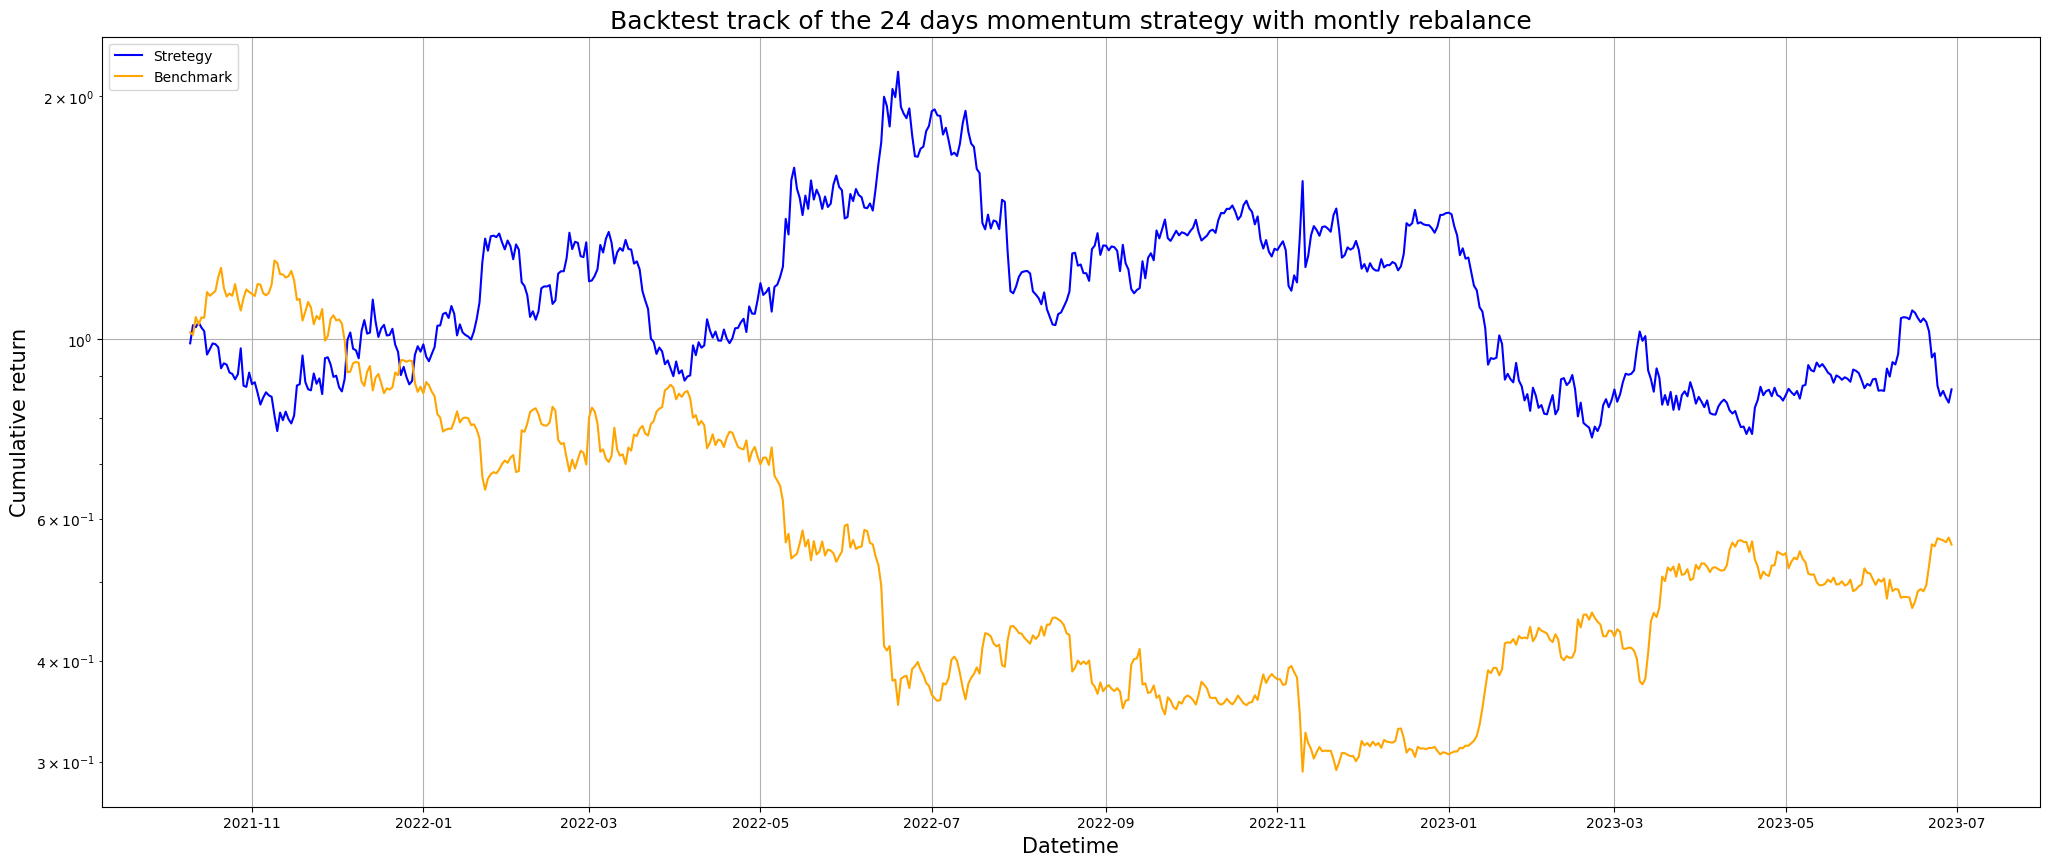

In [28]:
import matplotlib.pyplot as plt

f, ax = plt.subplots(1, 1, figsize=(25, 10))
ax.set_title(
    "Backtest track of the 24 days momentum strategy with montly rebalance", fontsize=18
)
ax.plot(
    returns_df["Startegy_cumulative_returns"],
    label="Stretegy",
    color="blue",
)

ax.plot(returns_df["Bench_cumulative_returns"], label="Benchmark", color="orange")
ax.set_xlabel("Datetime", fontsize=15)
ax.set_ylabel("Cumulative return", fontsize=15)
ax.legend(loc="upper left")
ax.set_yscale("log")

ax.grid()

In [29]:
from quant_invest_lab.reports import (
    print_portfolio_strategy_report,
    plot_from_trade_df_and_ptf_optimization,
)

print_portfolio_strategy_report(
    portfolio_returns=pd.Series(returns_histo, index=univers.index),
    benchmark_returns=univers["returns"]["bitcoin"],
    timeframe="1day",
)


-------  Returns statistical information  --------
Expected return annualized: 21.69 % vs -16.01 % (buy and hold)
CAGR: -7.35 % vs -29.67 % (buy and hold)
Expected volatility annualized: 77.60 % vs 59.81 % (buy and hold)
Specific volatility (diversifiable) annualized: 39.95 %
Systematic volatility annualized: 66.53 %
Skewness: 0.25 vs -0.16 (buy and hold), <0 = left tail, >0 = right tail
Kurtosis: 2.87 vs -0.16 (buy and hold) , >3 = fat tails, <3 = thin tails
1day-95%-VaR: -5.92 % vs -5.17 % (buy and hold) -> the lower the better
1day-95%-CVaR: -8.54 % vs -7.67 % (buy and hold) -> the lower the better

-------  Strategy statistical information  -------
Max drawdown: -64.76 % vs -76.72 % (buy and hold)
Kelly criterion: 1.88 % vs -2.01 % (buy and hold)
Benchmark sensitivity (beta): -1.11 vs 1 (buy and hold)
Excess return (alpha): 0.0001 vs 0 (buy and hold)
Jensen alpha: 0.0000
Determination coefficient R²: 0.74
Tracking error annualized: 132.50 %

---------------  Strategy ratios  -----

,Portfolio,Benchmark
Expected return,0.216936,-0.160112
CAGR,-0.073467,-0.296721
Expected volatility,0.775967,0.598135
Skewness,0.247665,-0.163139
Kurtosis,2.873268,3.892795
VaR,-0.059241,-0.051685
CVaR,-0.085405,-0.076736
Max drawdown,-0.647634,-0.767182
Kelly criterion,0.018763,-0.020089
Profit factor,1.041314,0.959901


In [30]:
alloc = pd.DataFrame(weights_df.mean())
alloc.columns = [0]
alloc = alloc.T


plot_from_trade_df_and_ptf_optimization(
    portfolio_returns=returns_df["Startegy_returns"],
    benchmark_returns=returns_df["Bench_returns"],
    asset_allocation_dataframe=alloc,
)

Loading BokehJS ...

Loading BokehJS ...

## Weights analysis


In [10]:
weights_df

,dogecoin,avalanche_2,solana,stellar,matic_network,chainlink,cardano,ethereum,tron,ripple,tezos,ethereum_classic,binancecoin,bitcoin,litecoin,dash,bitcoin_cash
date,,,,,,,,,,,,,,,,,
2021-01-30,0.125000,0.125000,0.125000,0.125000,0.125000,0.125000,0.125000,0.125000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
2021-01-31,0.170268,0.113400,0.118823,0.119949,0.121964,0.115304,0.118363,0.121930,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
2021-02-01,0.106312,0.121363,0.134956,0.136026,0.124713,0.123652,0.127288,0.125690,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
2021-02-02,0.138296,0.133444,0.132735,0.125365,0.117090,0.116092,0.119193,0.117785,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
2021-02-03,0.121723,0.126250,0.138271,0.127497,0.120804,0.113315,0.133810,0.118331,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-25,0.000000,0.108793,0.000000,0.118887,0.000000,0.118205,0.110952,0.149173,0.0,0.130592,0.0,0.0,0.108937,0.154461,0.0,0.0,0.0
2023-06-26,0.000000,0.107687,0.000000,0.121541,0.000000,0.121019,0.109564,0.149195,0.0,0.129240,0.0,0.0,0.106394,0.155361,0.0,0.0,0.0
2023-06-27,0.000000,0.110096,0.000000,0.121916,0.000000,0.120004,0.109470,0.149739,0.0,0.128822,0.0,0.0,0.106423,0.153530,0.0,0.0,0.0
